# Initialization

In [1]:
!pip install boto3 progressbar2 sfdmap GPUtil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 603.4 kB/s eta 0:00:00a 0:00:01
  Using cached progressbar2-4.0.0-py2.py3-none-any.whl (26 kB)
  Using cached sfdmap-0.1.1-py3-none-any.whl
  Using cached GPUtil-1.4.0-py3-none-any.whl
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.1 MB/s eta 0:00:00:00:0100:01
  Using cached jmespath-1.0.0-py3-none-any.whl (23 kB)
  Using cached python_utils-3.2.3-py2.py3-none-any.whl (20 kB)


In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_v2_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V2')
s3_v4_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V4')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

# Infer RF

## Loading data

In [3]:
# load data
print('Loading data and creating dataset')
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_v4_data_ver_dir_path,'gs_test_V4.pkl'))
X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_v2_data_ver_dir_path, 'spec.npy'))
full_wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'wl_grid.npy'))
wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_v4_data_ver_dir_path, 'wl_100K_V4.npy'))
start_i = (np.abs(full_wl_grid - wl_grid[0])).argmin()
end_i = 1+(np.abs(full_wl_grid - wl_grid[-1])).argmin()
X = X[gs.index, start_i:end_i]

Loading data and creating dataset
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/gs_test_V4.pkl
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/wl_grid.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/wl_100K_V4.npy


In [4]:
assert not np.any(np.isnan(X)), 'NaN!'

## Load RF

In [5]:
load_RF_name = 'simple___2022_05_10___11_24_58___100K_V4_full_data_set'
s3_load_dir_path = os.path.join(s3_saves_dir_path, 'RF', load_RF_name)
print('loading from folder (S3): {0}'.format(s3_load_dir_path))

from CustomRandomForest import CustomRandomForest
rf = CustomRandomForest.load_s3(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'crf.pkl'))

loading from folder (S3): almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/crf.pkl


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Predict on test set

In [6]:
print('Applying the RF (calculate leaves)')
X_leaves = rf.apply(X)

print('Predicting fully')
Y_hat = rf.predict_full_from_leaves(X_leaves)

print('Calculating the similarity matrix')
from CustomRandomForest import build_similarity_matrix
sim_mat = build_similarity_matrix(X_leaves, Y_hat)

Applying the RF (calculate leaves)
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


Predicting fully
Calculating the similarity matrix


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3010 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3496 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | e

assembling the matrix.


In [7]:
print('Calculating the distance matrix and weirdness scores')
dist_mat_hat_test_set = 1 - sim_mat
weird_scores_hat_test_set = np.mean(dist_mat_hat_test_set, axis=1)

Calculating the distance matrix and weirdness scores


# save

In [8]:
print('Saving the weirdness scores')
to_s3_npy(weird_scores_hat_test_set, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'weird_scores_hat_test_set.npy'))

print('Saving the dissimilarity matrix')
to_s3_npy(dist_mat_hat_test_set, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'dist_mat_hat_test_set.npy'))

Saving the weirdness scores
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/weird_scores_hat_test_set.npy
Saving the dissimilarity matrix
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/dist_mat_hat_test_set.npy


True

## TSNE and Histograms

In [9]:
print('Running T-SNE')
from sklearn.manifold import TSNE
sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dist_mat_hat_test_set)

Running T-SNE
[t-SNE] Computing 76 nearest neighbors...


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Indexed 10000 samples in 0.194s...
[t-SNE] Computed neighbors for 10000 samples in 1.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.021467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.185928
[t-SNE] KL divergence after 1000 iterations: 3.070401


In [10]:
print('Saving T-SNE')
to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'test_set_tsne.npy'))

Saving T-SNE
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/test_set_tsne.npy


True

Text(0.5, 0, 'weirdness score')

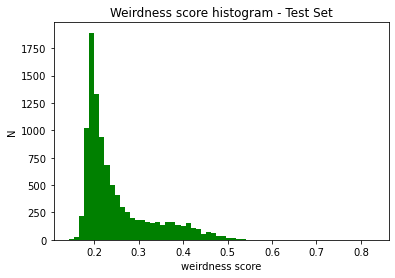

In [20]:
fig = plt.figure()
tmp = plt.hist(weird_scores_hat_test_set, bins=60, color="g")
plt.title("Weirdness score histogram - Test Set")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [13]:
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'weirdness_scores_histogram-test_set.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/weirdness_scores_histogram-test_set.png


True

Text(0.5, 0, 'distance')

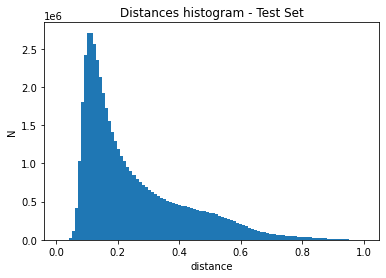

In [21]:
distances = dist_mat_hat_test_set[np.tril_indices(dist_mat_hat_test_set.shape[0], -1)]

fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("Distances histogram - Test Set")
plt.ylabel("N")
plt.xlabel("distance")

In [15]:
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'distances_histogram-test_set.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/distances_histogram-test_set.png


True

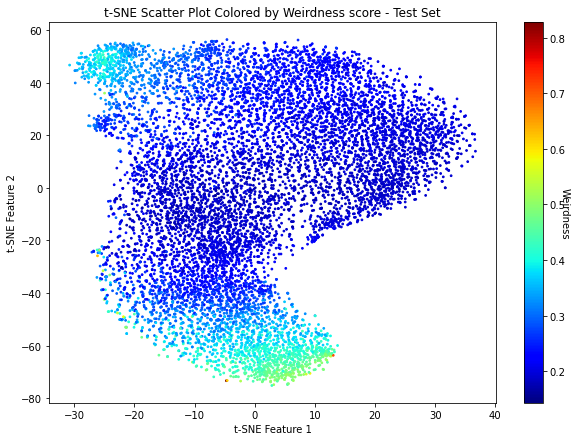

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(sne[:, 0], sne[:, 1], s=3, c=weird_scores_hat_test_set, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score - Test Set')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

In [18]:
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'tsne_colored_by_weirdness-test_set.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/tsne_colored_by_weirdness-test_set.png


True

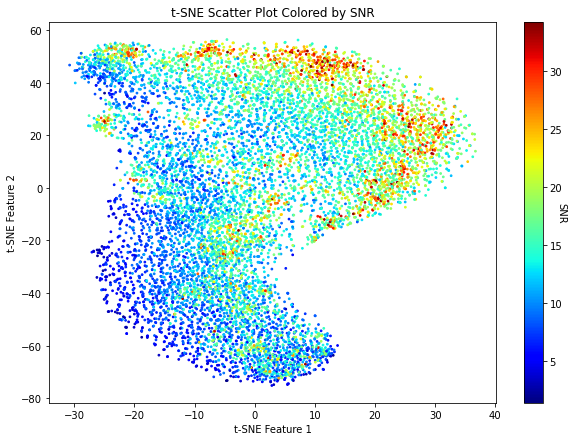

In [26]:
snr = gs.snMedian
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
import matplotlib.colors as colors
#im_scat = ax.scatter(sne[:, 0], sne[:, 1], s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
im_scat = ax.scatter(sne[:, 0], sne[:, 1], s=3, c=snr, cmap=plt.cm.get_cmap('jet'))
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by SNR')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('SNR', rotation=270)
plt.show()

In [27]:
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_load_dir_path, 'tsne_colored_by_snr-test_set.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_10___11_24_58___100K_V4_full_data_set/tsne_colored_by_snr-test_set.png


True